# Prediction of Podiums Obtained at MotoGP Events

This exercise is performed from the perspective of potential sponsors of MotoGP Events. Specifically, the question we will attempt to address is "As a potential sponsor of MotoGP, where should I invest my money to get the highest ROI?"

MotoGP is one of the biggest motorcycle competitions in the world, with [over 400 million fans estimated worlwide in 2021](https://motochronicle.com/how-many-motogp-fans-in-the-world/). Further, MotoGP gained \\$283 million from sponsorship in 2020. Clearly, a lot of money is at stake. From the perspective of a sponsor, there are a number of different approaches that can be taken to maximize ROI. For the purpose of this exercise, we will build a predictive model based on the assumption that maximizing positive air time (time a sponsor is shown in a positive manner on mediums such as television, online streaming services, etc) will result in an increase in sales for a given sponsor.

If a model that could predict podiums increased classification precision by even 5%, sponsors utilizing this model could see potentially tens of millions more fans purchasing their products, and given that motorcycle goods aren't particularly cheap, with cheaper accessories ranging in the \\$100's of dollars and high end consumer performance motorcycles in the mid five digit range and more, this could easily increase revenue for a sponsor by billions of dollars annually.

In [298]:
import warnings

import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_evaluations, plot_objective

from boruta import BorutaPy

from imblearn.over_sampling import SMOTENC

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import fbeta_score, make_scorer, precision_score, recall_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import learning_curve

warnings.filterwarnings('ignore')

In [200]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [3]:
df = pd.read_csv('./data/FILTERED_ROWS.csv')
df.head()

,year,category,sequence,shortname,circuit_name,rider,rider_name,team_name,bike_name,position,points,number,country,speed,time
0,1949,500cc,1,TT,Isle of Man,6,"Daniell, Harold",?,Norton,1,10.0,NaN,GB,NaN,3:02'18.600
1,1949,500cc,1,TT,Isle of Man,7,"Lockett, John",?,Norton,2,8.0,NaN,GB,NaN,0 Lap
2,1949,500cc,1,TT,Isle of Man,8,"Lyons, Ernie",?,Velocette,3,7.0,NaN,IE,NaN,0 Lap
3,1949,500cc,1,TT,Isle of Man,5,"Bell, Artie",?,Norton,4,6.0,NaN,IE,NaN,0 Lap
4,1949,500cc,1,TT,Isle of Man,12,"Jensen, Sid",?,Triumph,5,5.0,NaN,NZ,NaN,0 Lap


## Filter to MotoGP Category
The provided dataset includes data for all MotoSport categories from the beginning of the competition in 1949 up until 2021. For the purposes of this modeling exercises, we will limit the dataset only to the *"MotoGP"* category, which officially started in 2002. While technically the MotoGP category transitioned from the 500cc category and there could be an argument for including this data for modeling purposes as well, MotoSports are a fast changing series of competitions, with advances in technology playing a strong role in who is most competitive for a given series. Including data from the pre-MotoGP era would introduce a lot of data which is not particularly relevant, including various competitors, motorcycle models, engine sizes, etc. that are no longer active participants in the current format of MotoGP. Thus, to remove noise, we will focus only on the MotoGP category.

In [4]:
motogp_df = df[df['category'] == 'MotoGP'].copy()
motogp_df.head()

,year,category,sequence,shortname,circuit_name,rider,rider_name,team_name,bike_name,position,points,number,country,speed,time
28425,2002,MotoGP,1,JPN,Suzuka,1762,"Rossi, Valentino",?,Honda,1,25.0,NaN,IT,148.0,49'32.766
28426,2002,MotoGP,1,JPN,Suzuka,1977,"Ryo, Akira",?,Suzuki,2,20.0,NaN,JP,148.0,+1.550
28427,2002,MotoGP,1,JPN,Suzuka,1647,"Checa, Carlos",?,Yamaha,3,16.0,NaN,ES,147.6,+8.353
28428,2002,MotoGP,1,JPN,Suzuka,1343,"Ito, Shinichi",?,Honda,4,13.0,NaN,JP,147.5,+10.829
28429,2002,MotoGP,1,JPN,Suzuka,1664,"Abe, Norick",?,Yamaha,5,11.0,NaN,JP,147.0,+20.423


## Initial Feature Filtering
There are a number of features included as part of this dataset which can be removed:
1. category - Only the MotoGP category is being examined
2. shortname - This provides the same information as "circuit_name" and thus can be removed
3. rider - This provides the same information as "rider_name" and thus can be removed
4. position - This will be used to create the target value, "podium", after which it can be removed
5. points - While an argument could be made for examining cumulative points over a season to better predict who would win subsuquent races, the purpose of this exercise is to determine sponsorship at the beginning of a season. Thus, this feature will be removed.
6. number - This provides the same information as "rider_name" and thus can be removed
7. speed - This information is only available after a race has finished and as such can not be used for an upcoming season prediction
8. time - This information is only available after a race has finished and as such can not be used for an upcoming season prediction

In addition, we will create the feature *"podium"* based on the *"position"* feature, which will be used as the target variable. A Podium is defined as having achieved a position of first, second, or third in a race (thus, receiving an award on the podium for the race).

In [5]:
motogp_df['podium'] = np.where(motogp_df['position'].isin([1, 2, 3]), 1, 0)
motogp_df = motogp_df.drop(['category', 'shortname', 'rider', 'position', 'points', 'number', 'speed', 'time'], axis=1)
motogp_df.head()

,year,sequence,circuit_name,rider_name,team_name,bike_name,country,podium
28425,2002,1,Suzuka,"Rossi, Valentino",?,Honda,IT,1
28426,2002,1,Suzuka,"Ryo, Akira",?,Suzuki,JP,1
28427,2002,1,Suzuka,"Checa, Carlos",?,Yamaha,ES,1
28428,2002,1,Suzuka,"Ito, Shinichi",?,Honda,JP,0
28429,2002,1,Suzuka,"Abe, Norick",?,Yamaha,JP,0


In [6]:
motogp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7023 entries, 28425 to 56338
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   year          7023 non-null   int64 
 1   sequence      7023 non-null   int64 
 2   circuit_name  7023 non-null   object
 3   rider_name    7023 non-null   object
 4   team_name     7023 non-null   object
 5   bike_name     7023 non-null   object
 6   country       7023 non-null   object
 7   podium        7023 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 493.8+ KB


This leaves us with 7023 samples with no missing data to work with, a sufficiently small enough dataset such that we do not need to be overly concerned with issues relating to processing times of certain models. On the flip side, this should be sufficient enough samples to adequately train data on.

As a final step before proceeding to exploratory data analysis, we will convert all features of dtype *"object"* to *"category"* to improve overall performance.

In [7]:
object_columns = make_column_selector(dtype_include=object)
motogp_df[object_columns] = motogp_df[object_columns].astype('category')
motogp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7023 entries, 28425 to 56338
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   year          7023 non-null   int64   
 1   sequence      7023 non-null   int64   
 2   circuit_name  7023 non-null   category
 3   rider_name    7023 non-null   category
 4   team_name     7023 non-null   category
 5   bike_name     7023 non-null   category
 6   country       7023 non-null   category
 7   podium        7023 non-null   int64   
dtypes: category(5), int64(3)
memory usage: 274.1 KB


# Exploratory Data Analaysis
## Target Value Balance

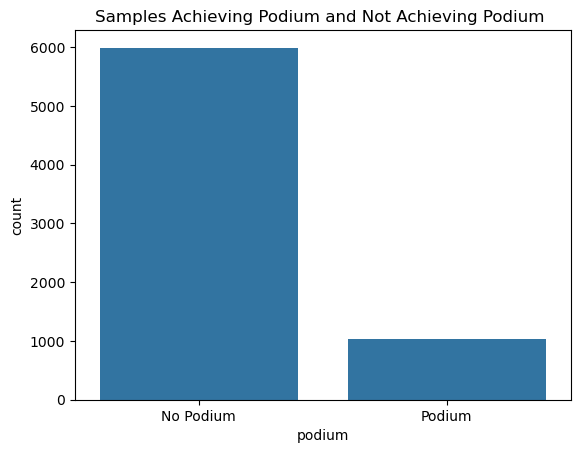

In [8]:
countplot = sns.countplot(motogp_df, x='podium')
countplot.set(title='Samples Achieving Podium and Not Achieving Podium ')
countplot.set_xticks([0, 1])
countplot.set_xticklabels(['No Podium', 'Podium'])
plt.show()

There is a significant imbalance between samples having a podium vs. those not having a podium, with a ratio of approximately 1:6. If this was simply a result of not having obtained a balanced dataset we would want to take steps to balance the data before modeling to prevent a unjustified bias during model training. However, in this case this is a realistic representation of the actual data. While the specific number of participants changes from season to season, for any given race, only the top three will receive a podium. Thus, whether it makes sense to balance the dataset or not is less clear.

As such, during model training, we will train models both with balanced and unbalanced datasets and compare their performance to determine which approach is more optimal.

## Podiums per Year

In [9]:
def plot_top_5_podiums_of_category(category):
    # Find podium sum per category per year
    category_podiums_sum = motogp_df.groupby([category, 'year'])[['podium']].sum()
    category_podiums_df = category_podiums_sum.reset_index()
    
    # Filter to top 5 of the given category
    category_top_5 = list(category_podiums_df.groupby(category)[['podium']].sum().sort_values(by='podium', ascending = False).index[:5])
    
    category_top_5_df = category_podiums_df.query("`{0}` in @category_top_5".format(category))
    category_top_5_df[category] = category_top_5_df[category].cat.remove_unused_categories()
    
    # Plot for the category between 2002 and 2021
    plt.figure(figsize = (20,20))
    lineplot = sns.lineplot(data=category_top_5_df, x='year', y='podium', hue=category)
    title = category.split("_")[0].capitalize()
    lineplot.set(title=f"Top 5 Podiums Per {title}")
    lineplot.set_xticks(range(2002, 2022))
    plt.show()

### Per Country

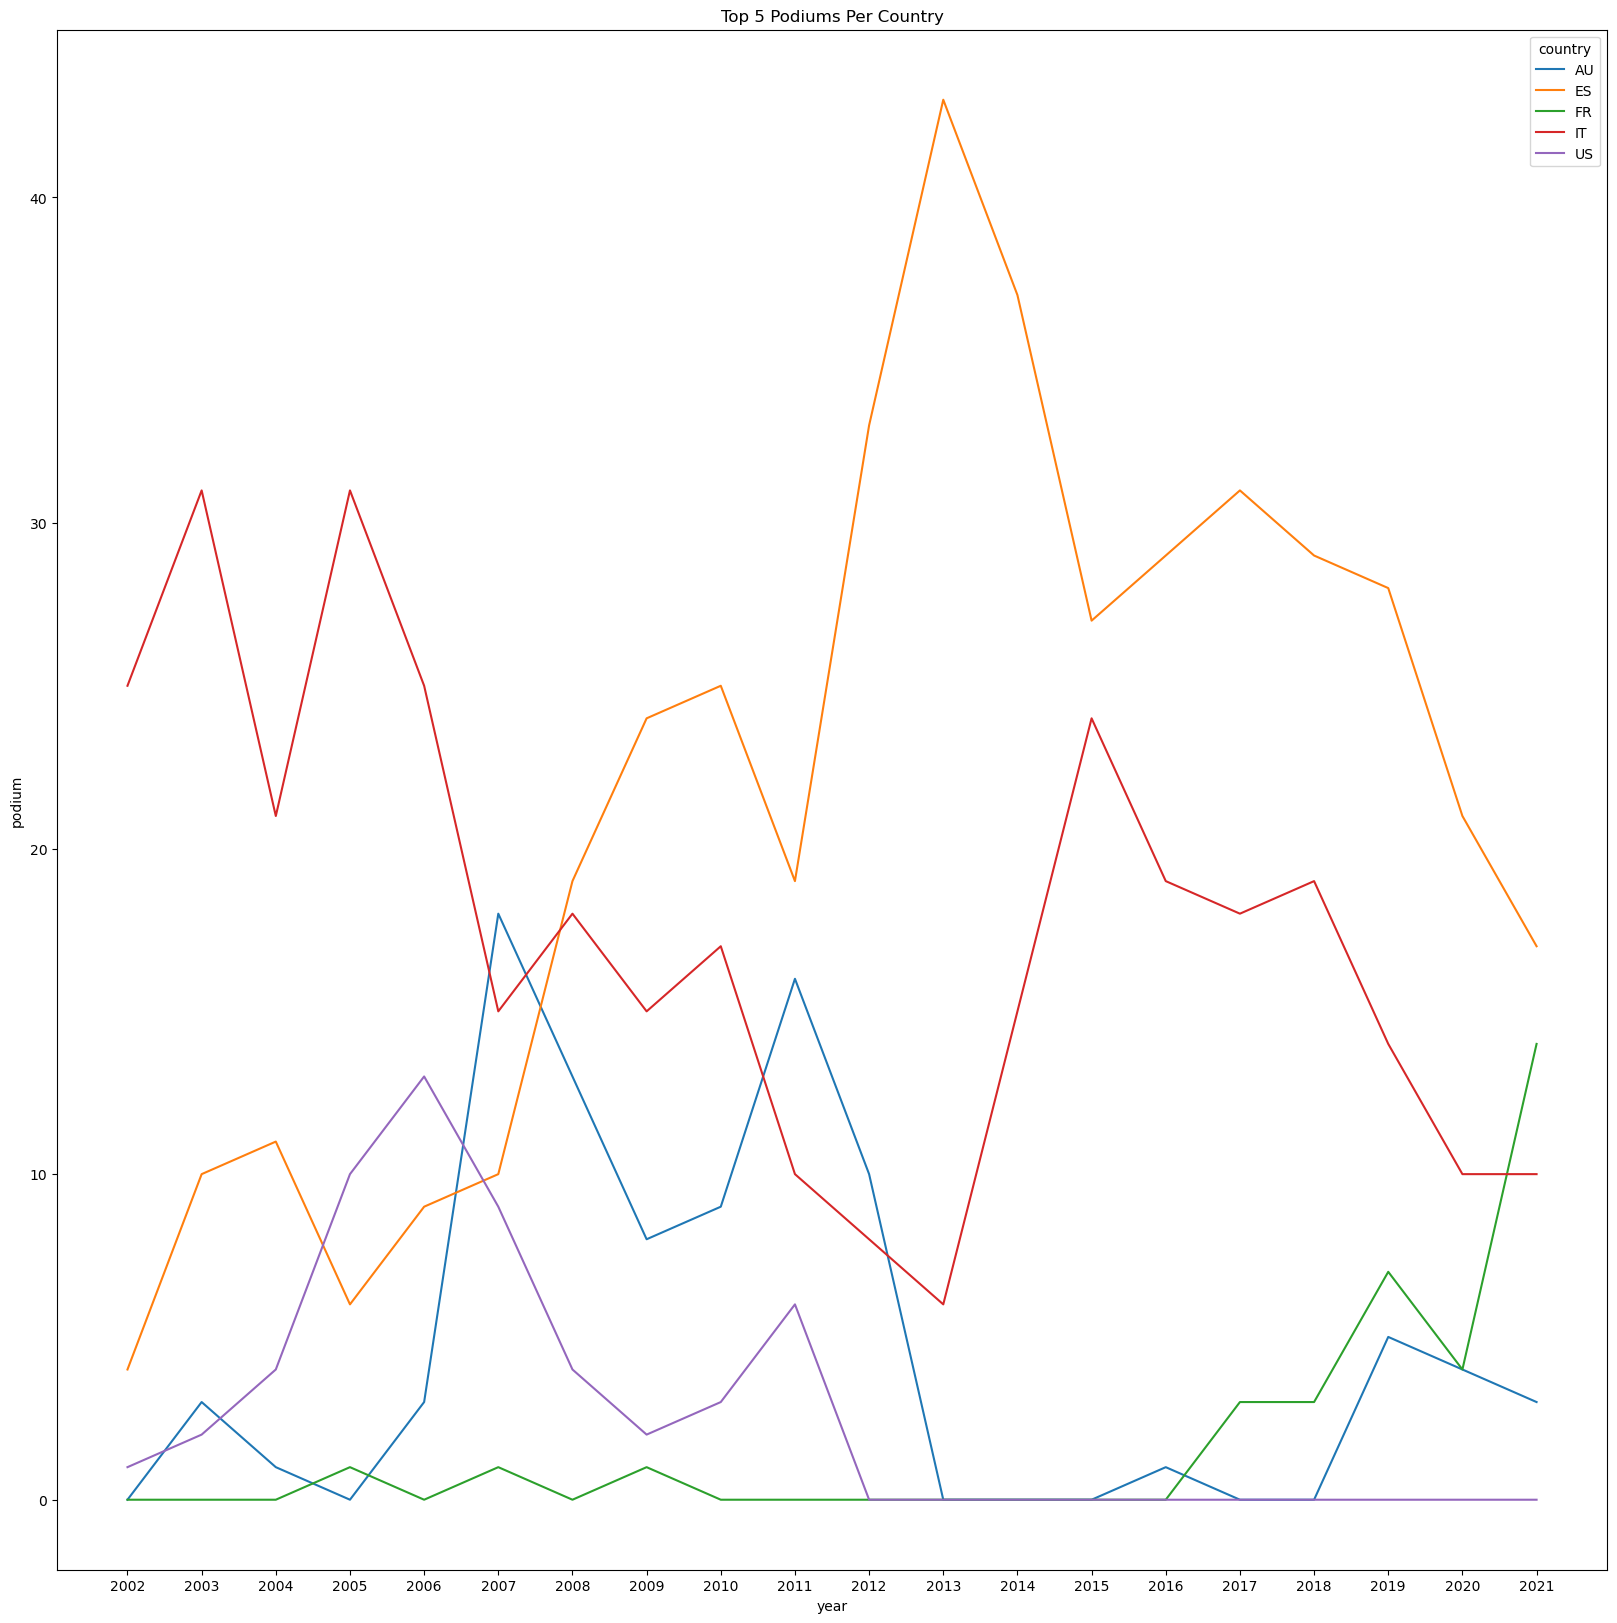

In [10]:
plot_top_5_podiums_of_category('country')

Looking at trends at the country level, we see that starting from around the late 2000's Spain began to dominate the competition. Following Spain is Italy which started off in the lead of the MotoGP competition and began to fall a bit as Spain took the lead. The other 3 countries have not performed as well, relatively speaking, however it appears that France has shown indications of becoming more competitive over the last few recent years.

### Per Bike Manufacturer

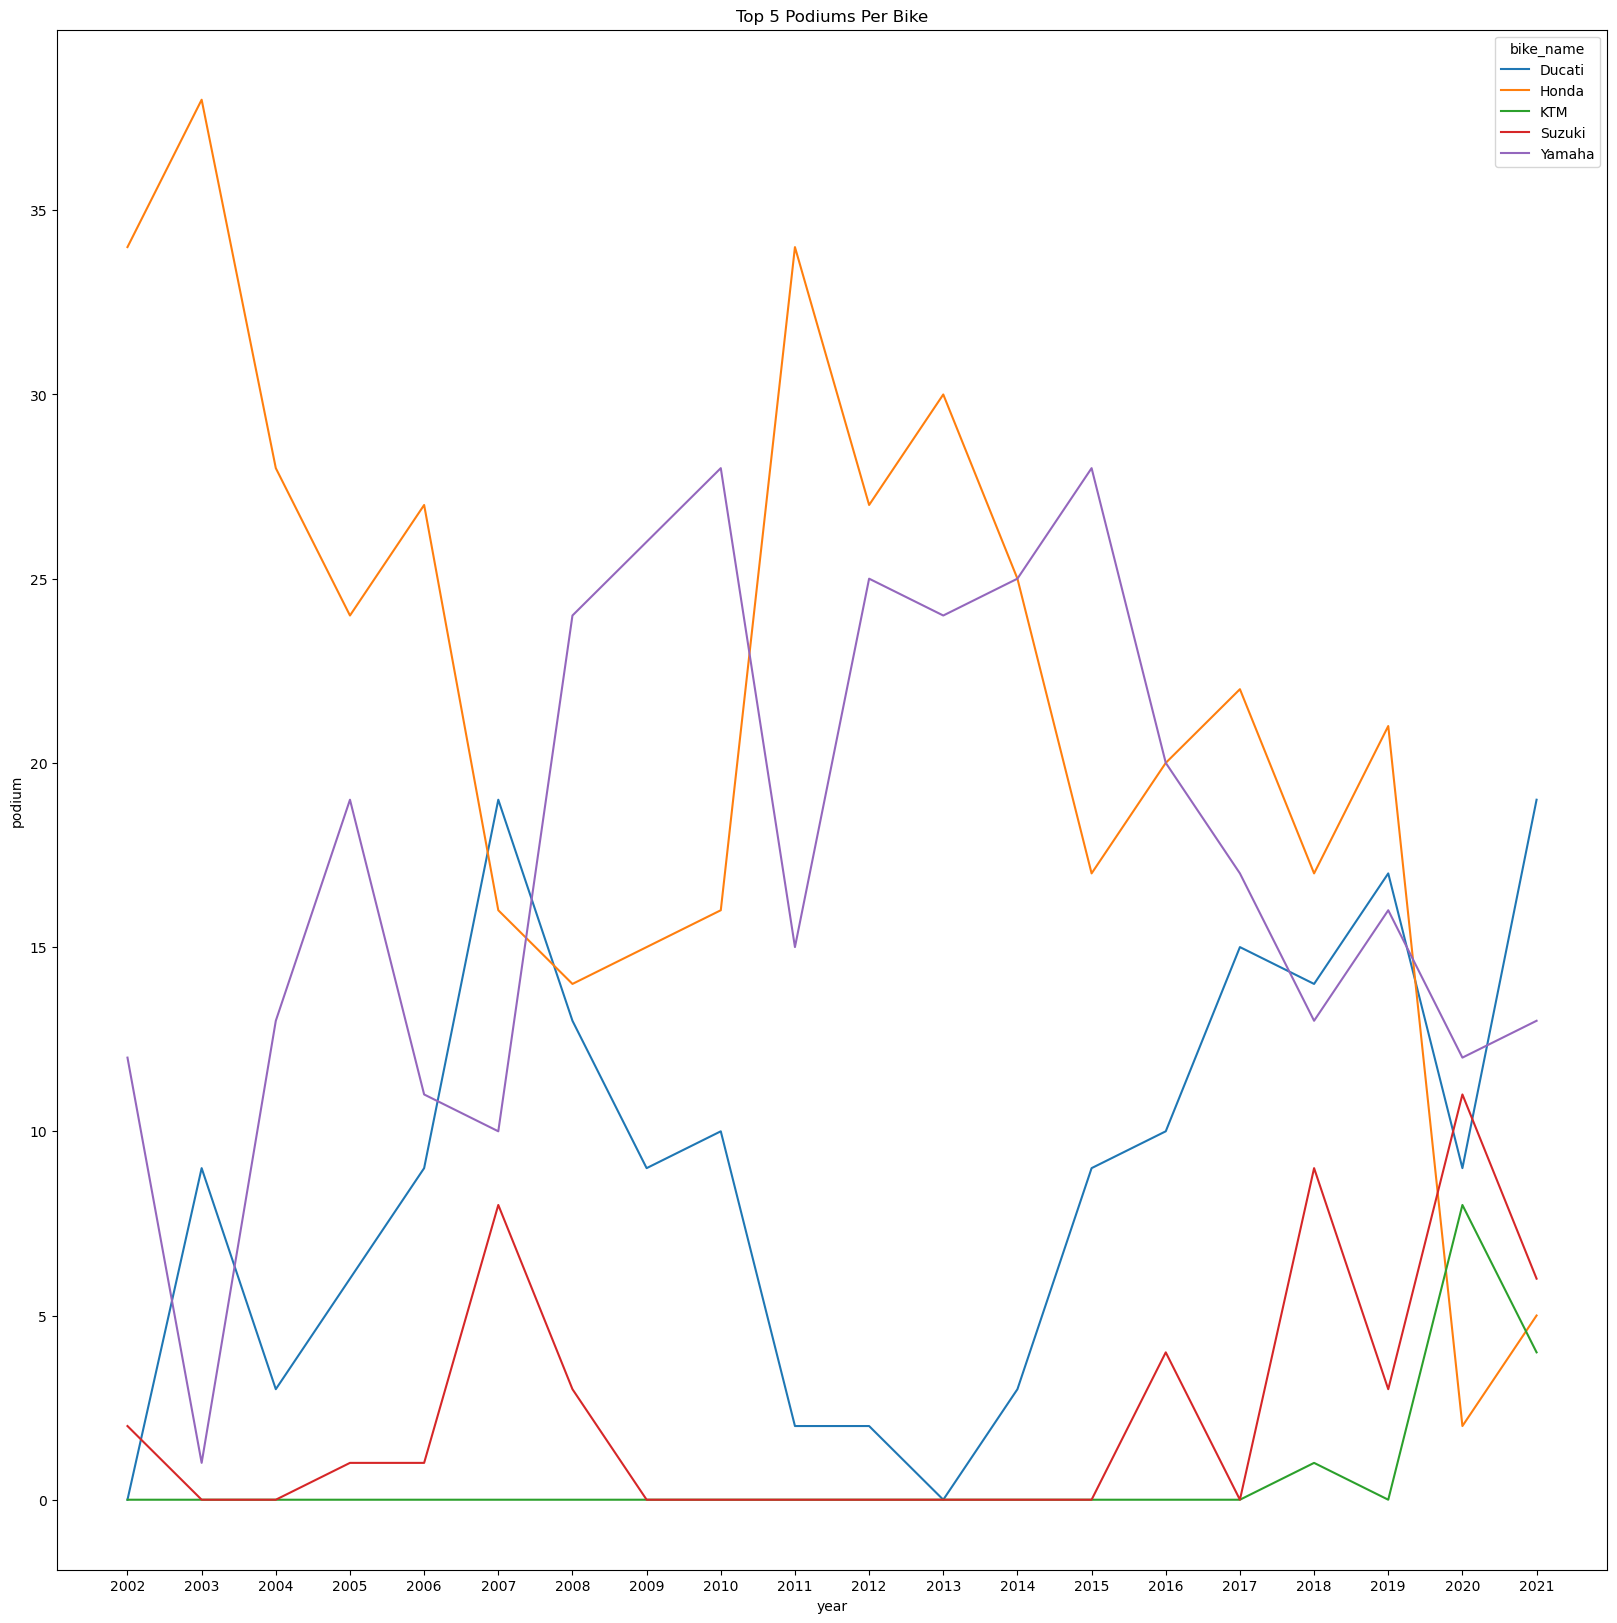

In [11]:
plot_top_5_podiums_of_category('bike_name')

Looking at trends per bike manufacturer, we see that up until the last few years Honda consistently had the highest number of podiums, with the exception of being beaten by Yamaha between 2008-2010 and 2014-2016. Since then the performance of Honda has dropped considerable, becoming one of the lowest performers in the top 5.

Yamaha has also done consistently well, placing as the second highest performer for most years, beating Honda for the periods mentioned above, and occassionally being beaten by Ducati in 2007, 2018, and 2021.

We see that Ducati demonstrated two periods of significant growth in performance, between 2002-2007 and 2013-2021.

While not included with this dataset, the above mentioned trends have continued in recent years, with Ducati taking a greater lead with most podiums, Yamaha maintaining a middle placement in the top 5, and Honda's performance continuing to decline. See the [Motorsport Stats MotoGP 2023 summary](https://www.motorsportstats.com/series/fim-motogp-world-championship/summary/2023) for more details.

### Per Rider

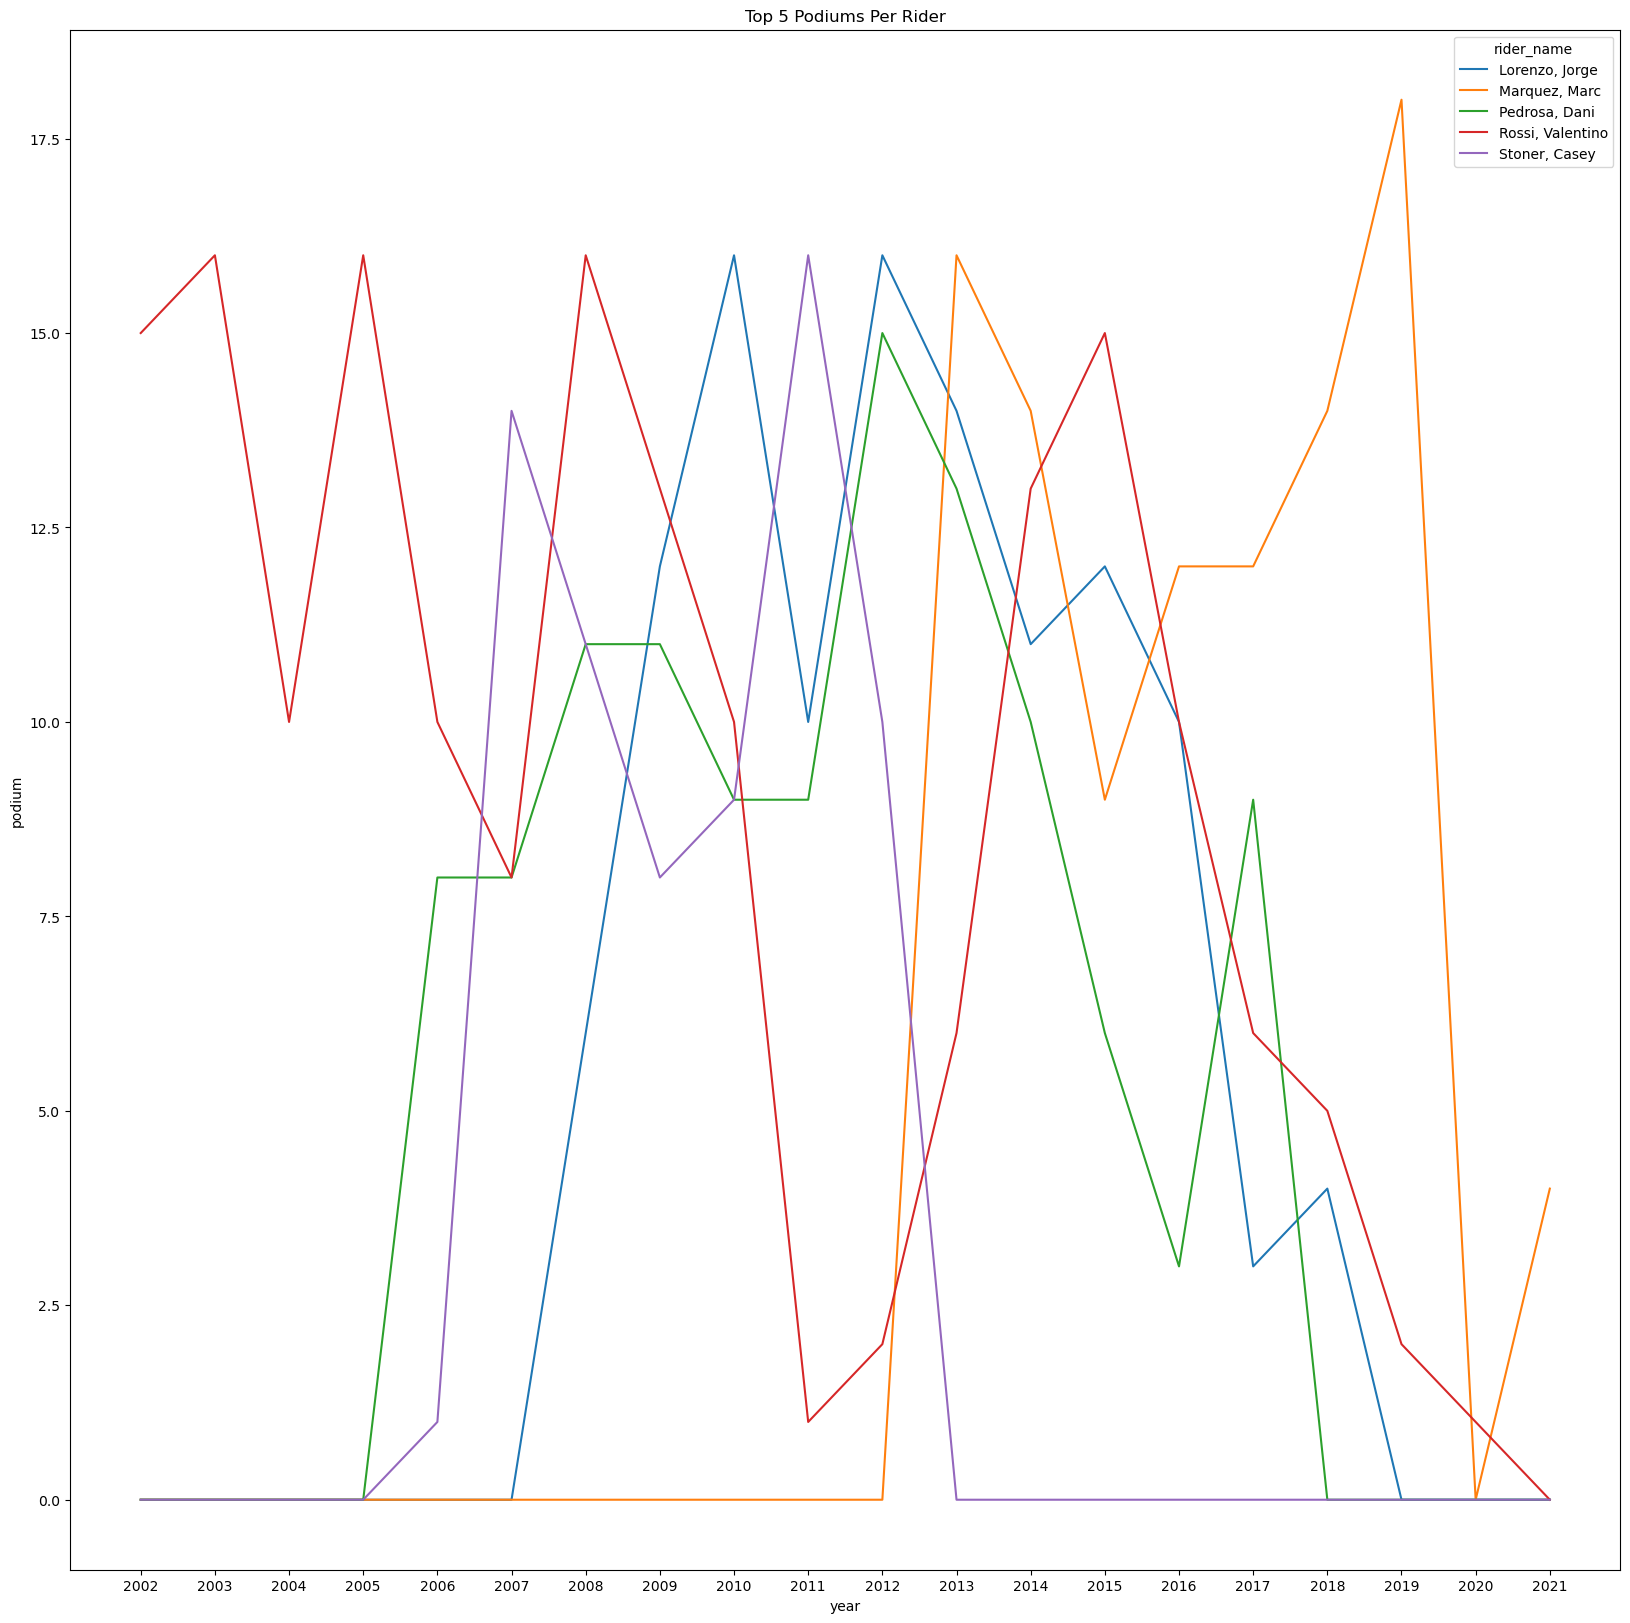

In [12]:
plot_top_5_podiums_of_category('rider_name')

At the individual rider level, we see a much higher level of variance from year to year. Any given top 5 rider may perform well one year and then quickly drop in performance the next. In general though the champion achieved around 16 podiums for a given season.

However, given the overall variance in performance at the individual rider level, a potential sponsor would likely see a much better ROI if they focused their investment at the bike manufacturer or rider country level.

# Modeling
For the purposes of this exercise, we will be using two different classifiers, *RandomForestClassifier*, and *XGBClassifier*. Both of these Ensemble-Type Classifiers are known for their performance, with [XGBoost winning more than half of the machine learning challenges on Kaggle](https://www.kdnuggets.com/2016/03/xgboost-implementing-winningest-kaggle-algorithm-spark-flink.html#:~:text=More%20than%20half%20of%20the,real%20world%20machine%20learning%20problems.). Additionally, as Decision Tree Based Classifiers, we have more options available for examining the importance of features. This is critical from a sponsor perspective, as we want to know what aspects of a racer play the biggest role when deciding where to invest.

We will use F0.5 and Precision Scores to assess performance. While we will also compare the performance of models trained on balanced data vs imbalanced data, F0.5 is a harmonic score which allows us to account for an imbalance in datasets with an emphasis on precision. Precision is the critical assessment we want to focus on as part of modeling, as sponsors will want to maximize the number of investments that actually achieve results.

Time measurements will not be included as part of assessment. As a model, the need to use this for prediction purposes is limited to a small period of time for a given season. As such, even if the amount of time needed for training was significant this would not be a major factor in determining the most optimal model.

In [13]:
f0point5_score = make_scorer(fbeta_score, beta=0.5)

In [14]:
X = motogp_df.drop('podium', axis=1)
y = motogp_df['podium']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [15]:
preprocesser = make_column_transformer(
    (OneHotEncoder(drop='if_binary', handle_unknown='ignore'), make_column_selector(dtype_include='category')),
    remainder='passthrough'
)

In [25]:
def build_model_with_pipeline(model):
    pipeline = Pipeline([
        ('preprocess', preprocesser),
        ('model', model)
    ])
    
    return pipeline

In [26]:
def fit_model_with_pipeline(model, X_train, y_train):
    pipeline = build_model_with_pipeline(model)
    pipeline.fit(X_train, y_train)
    
    return pipeline

In [108]:
model_list = []

In [114]:
def assess_performance_of_models(model_list):
    models_to_compare = {
        'model': [],
        'F0.5 Train Score': [],
        'F0.5 Test Score': [],
        'Precision Train Score': [],
        'Precision Test Score': []
    }
    
    for model in model_list:
        models_to_compare = add_model_for_comparison(models_to_compare, model)
    
    return pd.DataFrame(models_to_compare).set_index('model')

def add_model_for_comparison(models_to_compare, model):
    current_name = model['name']
    current_X, current_y = model['dataset']
    current_model = model['model']

    models_to_compare['model'].append(current_name)

    X_train, X_test, y_train, y_test = train_test_split(current_X, current_y, test_size=0.2, stratify=current_y, random_state=42)

    models_to_compare = add_f0point5_scores(models_to_compare, current_model, X_train, X_test, y_train, y_test)
    models_to_compare = add_precision_scores(models_to_compare, current_model, X_train, X_test, y_train, y_test)
    
    return models_to_compare

def add_f0point5_scores(models_to_compare, current_model, X_train, X_test, y_train, y_test):
    f0point5_train_score = round(np.mean(cross_val_score(current_model, X_train, y_train, scoring=f0point5_score)) * 100, 2)
    models_to_compare['F0.5 Train Score'].append(f0point5_train_score)
    
    f0point5_test_score = round(f0point5_score(current_model, X_test, y_test) * 100, 2)
    models_to_compare['F0.5 Test Score'].append(f0point5_train_score)
    
    return models_to_compare

def add_precision_scores(models_to_compare, current_model, X_train, X_test, y_train, y_test):
    precision_train_score = round(np.mean(cross_val_score(current_model, X_train, y_train, scoring='precision')) * 100, 2)
    models_to_compare['Precision Train Score'].append(precision_train_score)
    
    precision_test_preds = current_model.predict(X_test)
    precision_test_score = round(precision_score(y_test, precision_test_preds) * 100, 2)

    models_to_compare['Precision Test Score'].append(precision_test_score)
    
    return models_to_compare

## Baseline Models

In [109]:
rf = fit_model_with_pipeline(RandomForestClassifier(random_state=42), X_train, y_train)

In [110]:
model_list.append({'name': 'Random Forest - Baseline', 'dataset': (X, y), 'model': rf})

In [111]:
xgb = fit_model_with_pipeline(XGBClassifier(random_state=42), X_train, y_train)

In [112]:
model_list.append({'name': 'XGBoost - Baseline', 'dataset': (X, y), 'model': xgb})

In [115]:
assess_performance_of_models(model_list)

,F0.5 Train Score,F0.5 Test Score,Precision Train Score,Precision Test Score
model,,,,
Random Forest - Baseline,57.41,57.41,61.22,57.41
XGBoost - Baseline,58.99,58.99,62.83,59.51


## Feature Selection
Before comparing performance between imbalanced datasets with class_weight and a dataset that has been balanced, we will examine the current set of features to see if there is any benefit to reducing the set of features used.

For Feature Selection, we will be using the Boruta Algorithm. The [Boruta Github Repo](https://github.com/scikit-learn-contrib/boruta_py) describes the Boruta Algorithm as follows:

> Boruta is an all relevant feature selection method, while most other are minimal optimal; this means it tries to find all features carrying information usable for prediction, rather than finding a possibly compact subset of features on which some classifier has a minimal error.
>
> Why bother with all relevant feature selection? When you try to understand the phenomenon that made your data, you should care about all factors that contribute to it, not just the bluntest signs of it in context of your methodology (yes, minimal optimal set of features by definition depends on your classifier choice).

Essentially, filtering is based on whether a feature makes "x" amount of difference in model performance instead of choosing an arbitrary number of features.

In [46]:
fitted_preprocesser = preprocesser.fit(X)
X_transformed = fitted_preprocesser.transform(X)

In [50]:
feature_rf = RandomForestClassifier(random_state=42)
feature_rf_selector = BorutaPy(feature_rf, random_state=42)
feature_rf_selector.fit(X_transformed.toarray(), y.values.ravel())

BorutaPy(estimator=RandomForestClassifier(n_estimators=1000,
                                          random_state=RandomState(MT19937) at 0x13940F740),
         random_state=RandomState(MT19937) at 0x13940F740)

In [38]:
feature_xgb = XGBClassifier(random_state=42)
feature_xgb_selector = BorutaPy(feature_xgb, random_state=42)
feature_xgb_selector.fit(X_transformed.toarray(), y.values.ravel())

BorutaPy(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                                 colsample_bylevel=None, colsample_bynode=None,
                                 colsample_bytree=None,
                                 early_stopping_rounds=None,
                                 enable_categorical=False, eval_metric=None,
                                 feature_types=None, gamma=None, gpu_id=None,
                                 grow_policy=None, importance_type=None,
                                 interaction_constraints=None,
                                 learning_rate=None, max_bin=None,
                                 max_cat_threshold=None, max_cat_to_onehot=None,
                                 max_delta_step=None, max_depth=None,
                                 max_leaves=None, min_child_weight=None,
                                 missing=nan, monotone_constraints=None,
                                 n_estimators=1000, n_jobs=None,
                                 num_parallel_tree=None, predictor=None,
                                 random_state=1126556014, ...),
         random_state=RandomState(MT19937) at 0x13940FB40)

In [51]:
fitted_preprocesser.get_feature_names_out()[feature_rf_selector.support_]

array([], dtype=object)

In [48]:
fitted_preprocesser.get_feature_names_out()[feature_xgb_selector.support_]

array(['onehotencoder__rider_name_Aoyama, Hiroshi',
       'onehotencoder__rider_name_Barbera, Hector',
       'onehotencoder__rider_name_Battaini, Franco',
       'onehotencoder__rider_name_Biaggi, Max',
       'onehotencoder__rider_name_Dovizioso, Andrea',
       'onehotencoder__rider_name_Hernandez, Yonny',
       'onehotencoder__rider_name_Lorenzo, Jorge',
       'onehotencoder__rider_name_Pirro, Michele',
       'onehotencoder__rider_name_Rabat, Tito',
       'onehotencoder__rider_name_Rolfo, Roberto',
       'onehotencoder__rider_name_Rossi, Valentino',
       'onehotencoder__rider_name_Stoner, Casey',
       'onehotencoder__team_name_Avintia Racing',
       'onehotencoder__team_name_EG 0,0 Marc VDS',
       'onehotencoder__team_name_Honda LCR',
       'onehotencoder__team_name_Reale Avintia Racing',
       'onehotencoder__team_name_Repsol Honda Team',
       'onehotencoder__bike_name_ART', 'onehotencoder__bike_name_Aprilia',
       'onehotencoder__country_CZ', 'onehotencoder__co

Boruta shows that the categorical features "rider_name", "team_name", "bike_name", and "country" play a significant role in model prediction. Let's filter the DataFrame and examine the change in model performance.

In [116]:
X_filtered = motogp_df.drop(['year', 'sequence', 'podium'], axis=1)
y_filtered = motogp_df['podium']

X_filtered_train, X_filtered_test, y_filtered_train, y_filtered_test = train_test_split(X_filtered, y_filtered, test_size=0.2, stratify=y_filtered, random_state=42)

In [122]:
model_list = []

In [123]:
filtered_rf = fit_model_with_pipeline(RandomForestClassifier(random_state=42), X_filtered_train, y_filtered_train)

In [124]:
model_list.append({'name': 'Random Forest - Filtered', 'dataset': (X_filtered, y_filtered), 'model': filtered_rf})

In [125]:
filtered_xgb = fit_model_with_pipeline(XGBClassifier(random_state=42), X_filtered_train, y_filtered_train)

In [126]:
model_list.append({'name': 'XGBoost - Filtered', 'dataset': (X_filtered, y_filtered), 'model': filtered_xgb})

In [127]:
assess_performance_of_models(model_list)

,F0.5 Train Score,F0.5 Test Score,Precision Train Score,Precision Test Score
model,,,,
Random Forest - Filtered,52.80,52.80,54.56,56.42
XGBoost - Filtered,58.32,58.32,62.54,57.42


Filtering based on Boruta seems to show a slight degradation in model performance. As such we will keep all features of the original X and y sets.

## Class Imbalance
We will examine two different approaches to handling the class imbalance issue, addressing it with class_weight and by balancing the dataset.

### Class Weight

In [128]:
model_list = []

In [129]:
class_weight_rf = fit_model_with_pipeline(RandomForestClassifier(class_weight='balanced', random_state=42), X_train, y_train)

In [130]:
model_list.append({'name': 'Random Forest - Class Weight', 'dataset': (X, y), 'model': class_weight_rf})

In [131]:
class_weight_xgb = fit_model_with_pipeline(XGBClassifier(scale_pos_weight=(sum(y_train == 0) / sum(y_train == 1)), random_state=42), X_train, y_train)

In [132]:
model_list.append({'name': 'XGBoost - Class Weight', 'dataset': (X, y), 'model': class_weight_xgb})

In [133]:
assess_performance_of_models(model_list)

,F0.5 Train Score,F0.5 Test Score,Precision Train Score,Precision Test Score
model,,,,
Random Forest - Class Weight,57.28,57.28,61.37,57.50
XGBoost - Class Weight,52.44,52.44,48.78,44.41


### Balance Dataset

In [134]:
oversampler = SMOTENC(categorical_features='auto', random_state=42)
X_balanced, y_balanced = oversampler.fit_resample(X, y)
X_balanced_train, X_balanced_test, y_balanced_train, y_balanced_test = train_test_split(X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42)

In [135]:
model_list = []

In [136]:
balanced_rf = fit_model_with_pipeline(RandomForestClassifier(random_state=42), X_balanced_train, y_balanced_train)

In [137]:
model_list.append({'name': 'Random Forest - Balanced', 'dataset': (X_balanced, y_balanced), 'model': balanced_rf})

In [138]:
balanced_xgb = fit_model_with_pipeline(XGBClassifier(random_state=42), X_balanced_train, y_balanced_train)

In [139]:
model_list.append({'name': 'XGBoost - Balanced', 'dataset': (X_balanced, y_balanced), 'model': balanced_xgb})

In [140]:
assess_performance_of_models(model_list)

,F0.5 Train Score,F0.5 Test Score,Precision Train Score,Precision Test Score
model,,,,
Random Forest - Balanced,90.95,90.95,90.39,90.32
XGBoost - Balanced,89.73,89.73,89.05,87.97


Balancing the dataset indicates significantly better performance compared to using class weight to address the class imbalance. As such, the balanced dataset will be used for model training.

## Hyperparameter Tuning with BayesSearchCV
The traditional approach to hyperparameter tuning with Scikit-Learn is to take a grid of parameters to test against and use GridSearchCV to test every single potential iteration. This can be an expensive process and as such doesn't scale well against a large set of potential hyperparameters. 

RandomSearchCV has been shown to return better results on average, especially when multiple iterations are performed and evaluated.

More recently, Bayesian-type searches have become popular for their incremental learning approach to tuning. Scikit-Optimize is designed specifically to integrate with Scikit-Learn, adding Bayesian Optimization functionality to the library. As per the [Scikit-Optimize Site](https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html):

> Scikit-optimize provides a drop-in replacement for sklearn.model_selection.GridSearchCV, which utilizes Bayesian Optimization where a predictive model referred to as “surrogate” is used to model the search space and utilized to arrive at good parameter values combination as soon as possible.

BayesSearchCV will be used to further tune the Random Forest and XGBoost Classifiers fit with the balanced dataset.

### Random Forest

In [161]:
rf_pipe = build_model_with_pipeline(RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=42))

rf_search = {
    'model__n_estimators': Integer(1500, 3500),
    'model__max_depth': Integer(40, 60)
}

rf_opt = BayesSearchCV(
    rf_pipe,
    search_spaces=rf_search,
    scoring=f0point5_score,
    n_jobs=2,
    n_points=2,
    random_state=42
)

In [ ]:
rf_opt.fit(X_balanced_train, y_balanced_train)

In [163]:
rf_opt.best_params_

OrderedDict([('model__max_depth', 40), ('model__n_estimators', 2970)])

In [164]:
rf_opt.best_score_

0.9122557994226735

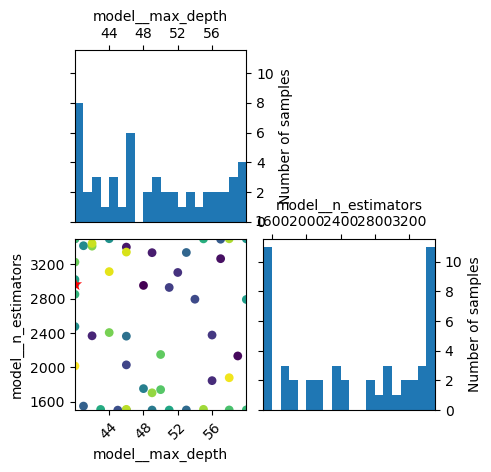

In [165]:
plot_evaluations(rf_opt.optimizer_results_[0])
plt.show()

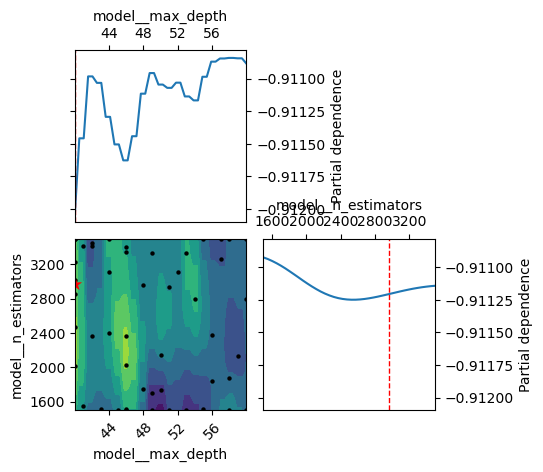

In [166]:
plot_objective(rf_opt.optimizer_results_[0])
plt.show()

### Random Forest - Results
Looking at the results from the parameter search above, we can observe a few things.

First, Random Forest has a clear preference for a high number of estimators. As can be seen from the n_estimator histogram, most searches were performed at the high end of the provided range of numbers. Looking at the related lineplot, we see that n_estimator has a strong partial dependence on model performance, reaching a local minimum around 2500. 

The max_depth number seems to indicate an optimal value with reasonable certainty. The related histogram is relatively even in its distribution with a slight trend towards left center. Likewise, we see the related lineplot have a local minimum around 46, and drops off as it approaches 40. This is a relatively high value for max_depth and as such we will want to examine the model more closely for potential overfitting.

Looking at the heatmap it may be worth manually exploring a classifier with n_estimators = 2400, max_depth = 40. This may be slightly lower in performance but with a faster fit time.

In [179]:
rf_optimal = fit_model_with_pipeline(RandomForestClassifier(
    criterion='entropy', 
    max_depth=40, 
    n_estimators=2400, 
    n_jobs=-1, 
    random_state=42
), X_balanced_train, y_balanced_train)

In [180]:
f0point5_score(rf_optimal, X_balanced_train, y_balanced_train)

0.9901891791199239

### XGBoost

In [173]:
xgb_pipe = build_model_with_pipeline(XGBClassifier(n_jobs=-1, random_state=42))

xgb_search = {
    'model__lambda': Integer(0, 1000),
    'model__max_depth': Integer(1, 200),
    'model__eta': Real(0, 1),
}

xgb_opt = BayesSearchCV(
    xgb_pipe,
    search_spaces=xgb_search,
    scoring=f0point5_score,
    n_jobs=2,
    n_points=2,
    random_state=42
)

In [ ]:
xgb_opt.fit(X_balanced_train, y_balanced_train)

In [175]:
xgb_opt.best_params_

OrderedDict([('model__eta', 0.30142783966834596),
             ('model__lambda', 0),
             ('model__max_depth', 200)])

In [176]:
xgb_opt.best_score_

0.9093913151748941

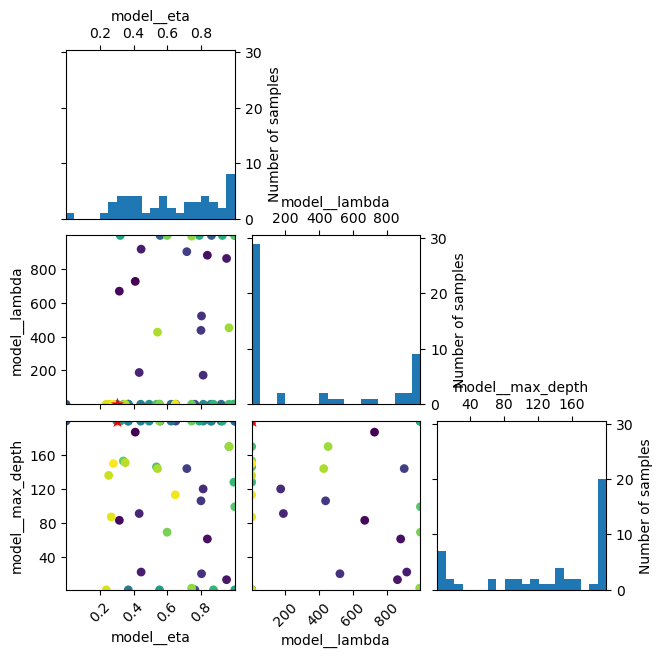

In [177]:
plot_evaluations(xgb_opt.optimizer_results_[0])
plt.show()

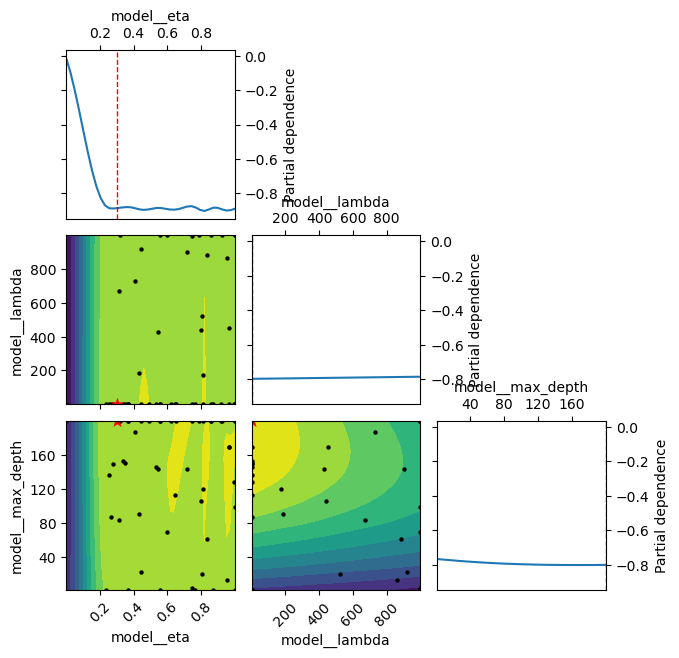

In [178]:
plot_objective(xgb_opt.optimizer_results_[0])
plt.show()

### XGBoost - Results
A number of observations can be made from the XGBoost results.

It seems that the hyperparameters lambda and max_depth, while playing a fairly significant role in model performance, don't seem to have much variation in regards to different values. Optimal max_depth was reported as 200, however looking at the plots above we should be able to safely reduce this value to decrease the chances of overfitting. Still, given the results for the ranges observed, we will want to check for overfitting.

Eta (Scikit-Learn's Learning Rate) indicated a significant increase in importance from 0-0.2, after which it levels off. Given the relevant heatmap, we will examine the performance of a model with eta = 0.6 and max_depth = 120

In [182]:
xgb_optimal = fit_model_with_pipeline(XGBClassifier(
    eta=0.6, 
    max_depth=120, 
    n_jobs=-1, 
    random_state=42
), X_balanced_train, y_balanced_train)

In [183]:
f0point5_score(xgb_optimal, X_balanced_train, y_balanced_train)

0.9911310041858343

In [184]:
model_list = []

In [185]:
model_list.append({'name': 'Random Forest - Optimal', 'dataset': (X_balanced, y_balanced), 'model': rf_optimal})

In [186]:
model_list.append({'name': 'XGBoost - Optimal', 'dataset': (X_balanced, y_balanced), 'model': xgb_optimal})

In [187]:
assess_performance_of_models(model_list)

,F0.5 Train Score,F0.5 Test Score,Precision Train Score,Precision Test Score
model,,,,
Random Forest - Optimal,91.24,91.24,90.74,90.22
XGBoost - Optimal,90.76,90.76,90.30,90.32


## Learning Curves
To check for overfitting behavior, we will plot the learning curves for the optimized models. This will compare the training and cross-validation scores across a variety of train sizes and show us how much difference there is in performance.

In [202]:
def plot_learning_curve(estimator, estimator_name, X, y, cv, train_sizes, scoring='accuracy'):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring=scoring, n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(f"{estimator_name} Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel(scoring)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    
    return plt

### Random Forest
#### F0.5 Score

/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0, 1, 2, 3] during transform. These unknown categories will be encod

/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded 

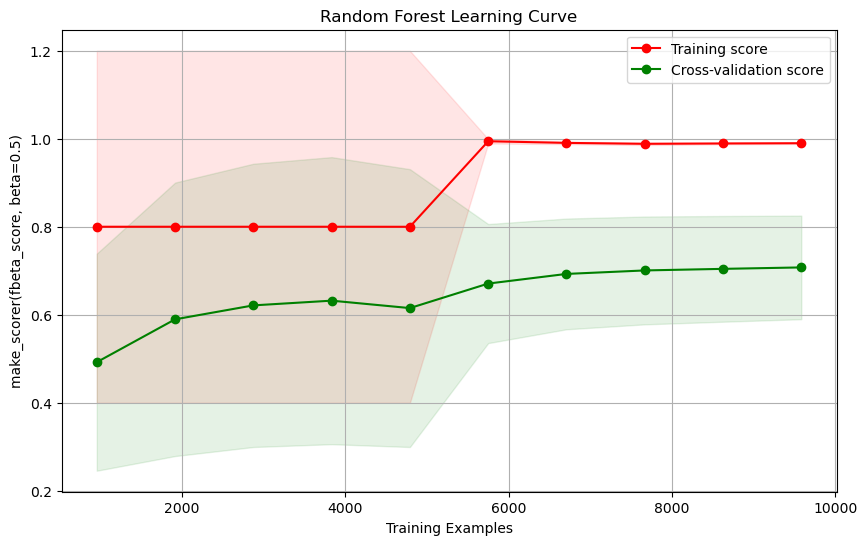

In [203]:
estimator = rf_optimal
estimator_name = 'Random Forest'
cv = 5
train_sizes = np.linspace(0.1, 1.0, 10) 
scoring = f0point5_score
plot_learning_curve(estimator, estimator_name, X_balanced, y_balanced, cv, train_sizes, scoring)
plt.show()

#### Precision Score

/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division

/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded 

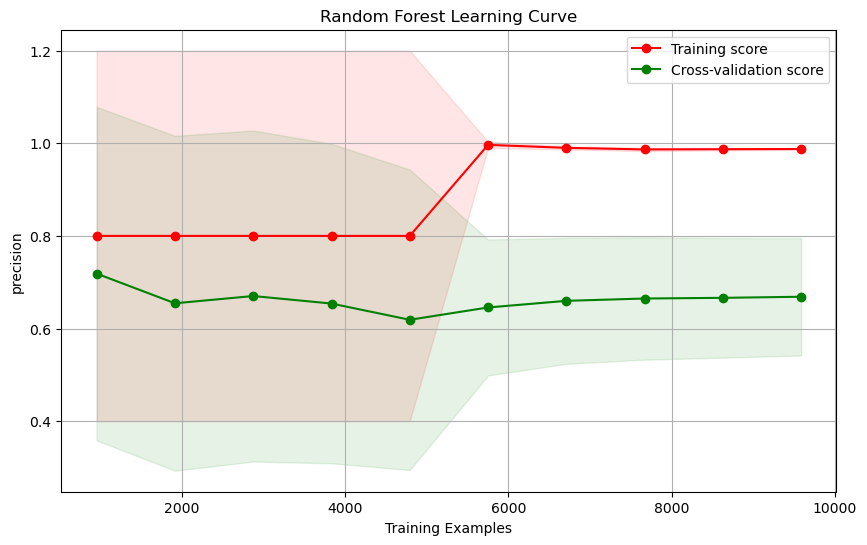

In [205]:
estimator = rf_optimal
estimator_name = 'Random Forest'
cv = 5
train_sizes = np.linspace(0.1, 1.0, 10) 
scoring = 'precision'
plot_learning_curve(estimator, estimator_name, X_balanced, y_balanced, cv, train_sizes, scoring)
plt.show()

### XGBoost
#### F0.5 Score

/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/user/anaconda3/envs/capstone/lib/pyth

/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/use

/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/user/anaconda3/en

/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.

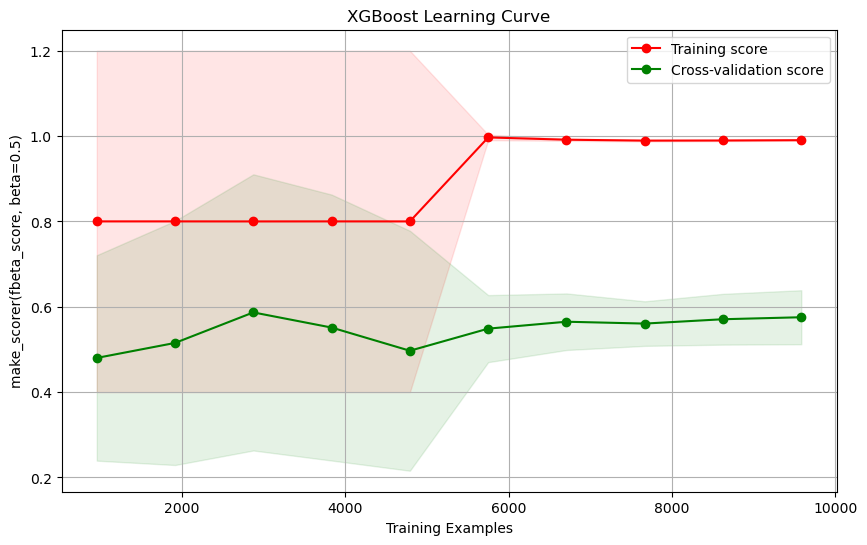

In [204]:
estimator = xgb_optimal
estimator_name = 'XGBoost'
cv = 5
train_sizes = np.linspace(0.1, 1.0, 10) 
scoring = f0point5_score
plot_learning_curve(estimator, estimator_name, X_balanced, y_balanced, cv, train_sizes, scoring)
plt.show()

#### Precision Score

/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be en

/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/user/anaconda3/envs/capstone/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded 

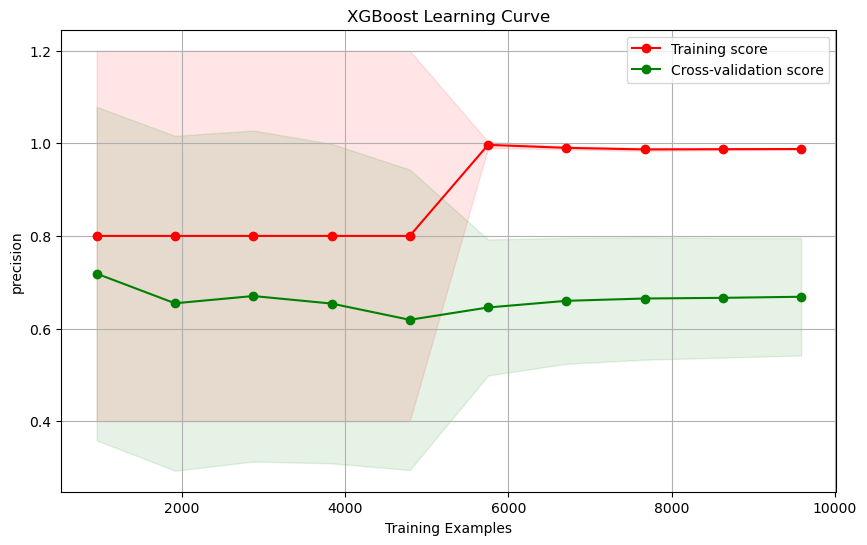

In [206]:
estimator = rf_optimal
estimator_name = 'XGBoost'
cv = 5
train_sizes = np.linspace(0.1, 1.0, 10) 
scoring = 'precision'
plot_learning_curve(estimator, estimator_name, X_balanced, y_balanced, cv, train_sizes, scoring)
plt.show()

### Check Scores Against Different Max Depth Values
On the one hand, the learning curves show us that we have used a sufficient number of samples to effectively train our model. On the other hand, we seem to be experiencing somewhat of a difference between train and cross validation scores. Let's take a closer look at how score changes against various max depth scores.

#### Random Forest

In [235]:
def plot_rf_max_depth_scores(X, y, max_depth_values, title, train_sizes=np.linspace(.1, 1.0, 10)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    train_scores = []
    test_scores = []
    
    for max_depth in max_depth_values:
        
        model =  fit_model_with_pipeline(RandomForestClassifier(
            criterion='entropy', 
            max_depth=max_depth, 
            n_estimators=2400, 
            n_jobs=-1, 
            random_state=42
        ), X_train, y_train)
        
        train_score = round(np.mean(cross_val_score(model, X_train, y_train, scoring=f0point5_score)) * 100, 2)
        test_score = round(f0point5_score(model, X_test, y_test) * 100, 2)
        
        train_scores.append(train_score)
        test_scores.append(test_score)

    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.xlabel("Max Depth Values")
    plt.ylabel(scoring)
    plt.grid()
    plt.plot(max_depth_values, train_scores, 'o-', label="Training score")
    plt.plot(max_depth_values, test_scores, 'o-', label="Test score")
    plt.legend(loc="best")
    
    return plt

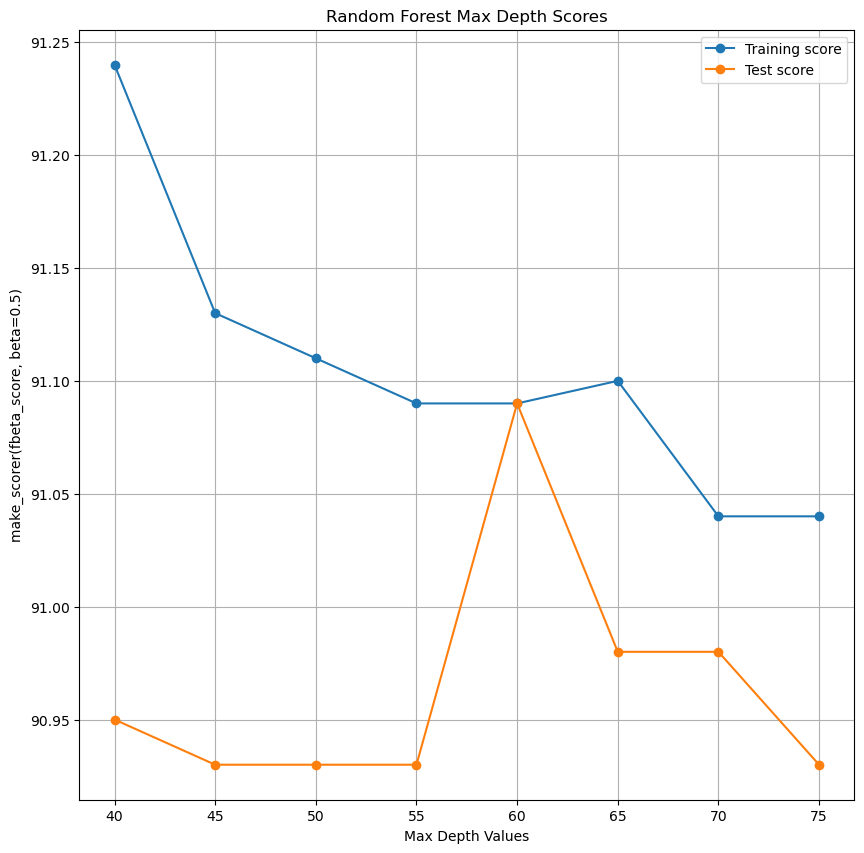

In [239]:
max_depth_values = range(40, 80, 5)
title = 'Random Forest Max Depth Scores'
plot_rf_max_depth_scores(X_balanced, y_balanced, max_depth_values, title)
plt.show()

Examining the scores for Random Forest with various max_depth values, we see that while a max_depth value of 40 had the optimal training score, it appears to be overfitting a bit compared to slightly higher scores. As such, we will adjust the value to your 60 for the final model.

In [244]:
rf_final = fit_model_with_pipeline(RandomForestClassifier(
    criterion='entropy', 
    max_depth=60, 
    n_estimators=2400, 
    n_jobs=-1, 
    random_state=42
), X_balanced_train, y_balanced_train)

#### XGBoost

In [231]:
def plot_xgb_max_depth_scores(X, y, max_depth_values, title, train_sizes=np.linspace(.1, 1.0, 10)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    train_scores = []
    test_scores = []
    
    for max_depth in max_depth_values:
        
        model = fit_model_with_pipeline(XGBClassifier(
            eta=0.6, 
            max_depth=max_depth, 
            n_jobs=-1, 
            random_state=42
        ), X_train, y_train)
        
        train_score = round(np.mean(cross_val_score(model, X_train, y_train, scoring=f0point5_score)) * 100, 2)
        test_score = round(f0point5_score(model, X_test, y_test) * 100, 2)
        
        train_scores.append(train_score)
        test_scores.append(test_score)

    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.xlabel("Max Depth Values")
    plt.ylabel(scoring)
    plt.grid()
    plt.plot(max_depth_values, train_scores, 'o-', label="Training score")
    plt.plot(max_depth_values, test_scores, 'o-', label="Test score")
    plt.legend(loc="best")
    
    return plt

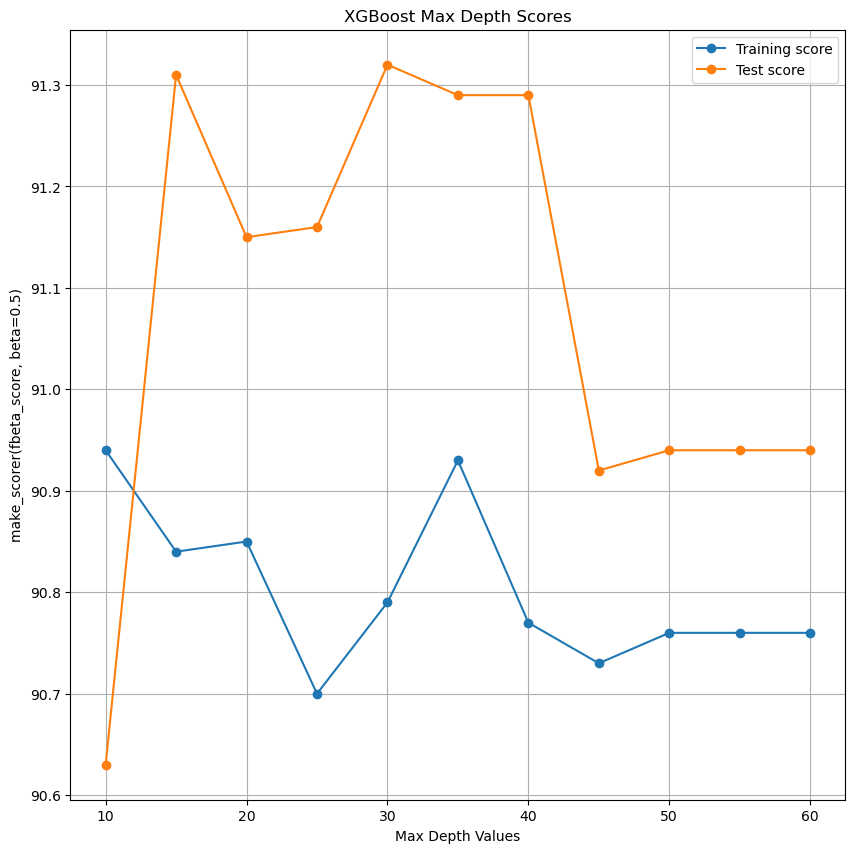

In [234]:
max_depth_values = range(10, 65, 5)
title = 'XGBoost Max Depth Scores'
plot_xgb_max_depth_scores(X_balanced, y_balanced, max_depth_values, title)
plt.show()

The score plots show us that while our initial hyperparameter search indicated a much higher value for max_depth, we are actually not seeing any benefit above 50 for XGBoost. Otherwise, the difference between train and test scores is marginal. As such, the max_depth value will be adjusted to 50 for the final model of XGBoost

In [238]:
xgb_final = fit_model_with_pipeline(XGBClassifier(
    eta=0.6, 
    max_depth=50, 
    n_jobs=-1, 
    random_state=42
), X_balanced_train, y_balanced_train)

In [250]:
model_list = []

In [251]:
model_list.append({'name': 'Random Forest - Final', 'dataset': (X_balanced, y_balanced), 'model': rf_final})

In [252]:
model_list.append({'name': 'XGBoost - Final', 'dataset': (X_balanced, y_balanced), 'model': xgb_final})

In [253]:
assess_performance_of_models(model_list)

,F0.5 Train Score,F0.5 Test Score,Precision Train Score,Precision Test Score
model,,,,
Random Forest - Final,91.09,91.09,90.51,90.38
XGBoost - Final,90.76,90.76,90.30,90.32


## Confusion Matrix
Next we will examine the performance of models using a confusion matrix.

### Random Forest

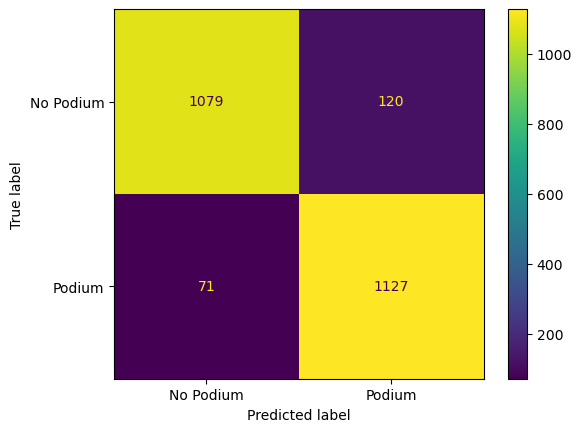

In [257]:
ConfusionMatrixDisplay.from_estimator(rf_final, X_balanced_test, y_balanced_test, display_labels=['No Podium', 'Podium'])

### XGBoost

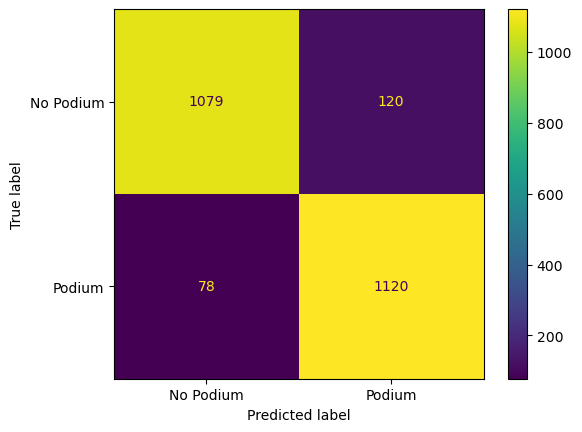

In [258]:
ConfusionMatrixDisplay.from_estimator(xgb_final, X_balanced_test, y_balanced_test, display_labels=['No Podium', 'Podium'])

The confusion matrices are inline with our F0.5 and Precisicion Scores, most samples predicted as obtaining a podium actually received a podium. However, there are a number of samples incorrectly being predicted as having obtained a podium. Let's examine the precision-recall curve to see if there is any potential for score improvement.

## Precision Recall Curve
### Random Forest

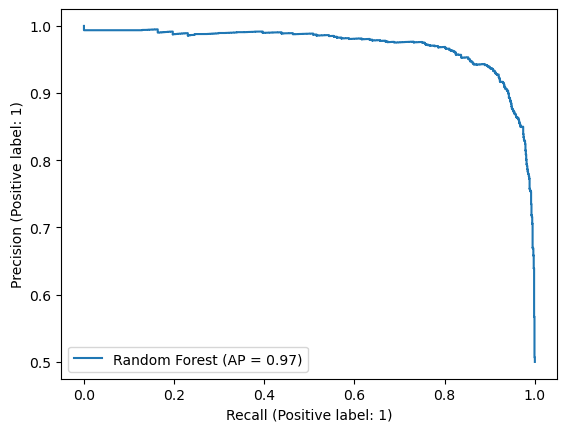

In [262]:
PrecisionRecallDisplay.from_estimator(rf_final, X_balanced_test, y_balanced_test, name='Random Forest')

### XGBoost

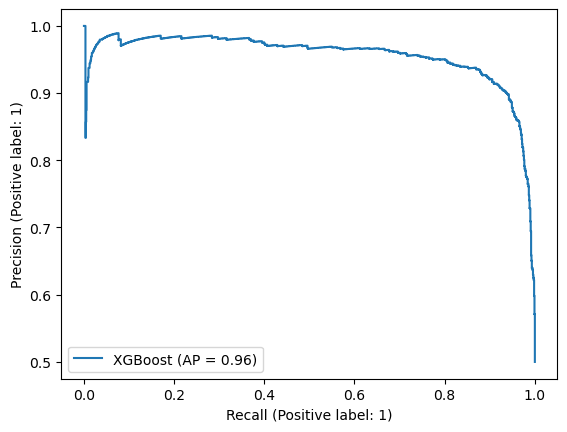

In [263]:
PrecisionRecallDisplay.from_estimator(xgb_final, X_balanced_test, y_balanced_test, name='XGBoost')

Recall Scores for both Random Forest and XGBoost drop rapidly for increases in Precision Score. Given that precision is more important for the puprose of this problem set, this loss is negligible. Let's take a closer look at Precision Score related to various Decision Thresholds.

## Decision Threshold vs. Precision Score

In [287]:
def plot_precision_score_against_decision_threshold(estimator, X, y, thresholds):
    probs = estimator.predict_proba(X)
    decision_thresholds = [x for x in np.arange(0.05, 1.00, 0.05)]
    
    precision_scores = [precision_score(y, (probs[:,1] >= decision_threshold).astype(int)) for decision_threshold in decision_thresholds]

    plt.plot(decision_thresholds, precision_scores, '--o')
    plt.title(f'{estimator[-1].__class__.__name__} Decision Threshold vs. Precision Score')
    plt.xlabel('Decision Threshold')
    plt.ylabel('Precision Score')
    plt.grid();
    
    return plt

### Random Forest

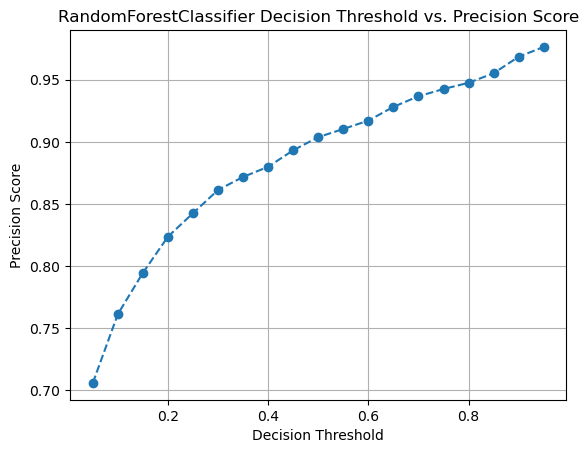

In [289]:
plot_precision_score_against_decision_threshold(rf_final, X_balanced_test, y_balanced_test, np.arange(0.05, 1.00, 0.05))
plt.show()

### XGBoost

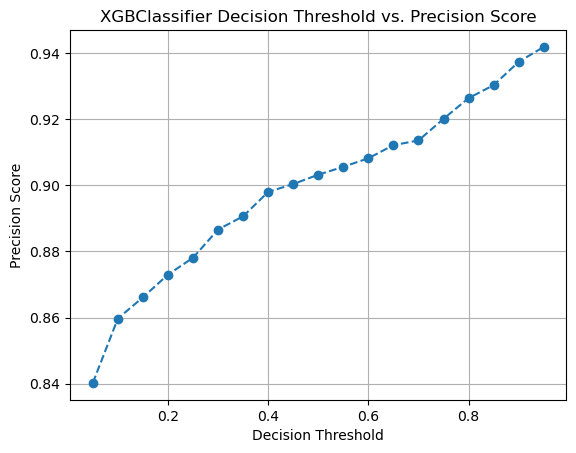

In [288]:
plot_precision_score_against_decision_threshold(xgb_final, X_balanced_test, y_balanced_test, np.arange(0.05, 1.00, 0.05))
plt.show()

It seems we can gain a jump in Precision Score of about 4-5% if we push the Decision Threshold to around 0.9. Let's examine how scores change at that level.

## Confusion Matrix - Decision Threshold of 0.9

### Random Forest

In [293]:
rf_probs = rf_final.predict_proba(X_balanced_test)
rf_preds = (rf_probs[:, 1] >= 0.9).astype(int)

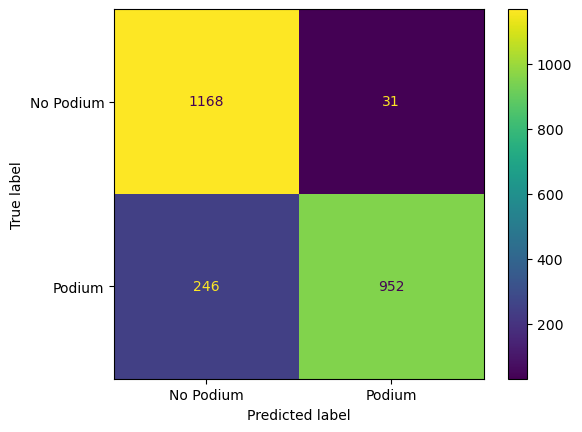

In [294]:
ConfusionMatrixDisplay.from_predictions( y_balanced_test, rf_preds, display_labels=['No Podium', 'Podium'])

In [297]:
rf_precision_score = precision_score(y_balanced_test, rf_preds)
rf_precision_score

0.9684638860630722

In [300]:
rf_recall_score = recall_score(y_balanced_test, rf_preds)
rf_recall_score

0.7946577629382304

In [301]:
rf_f05_score = (1.25 * rf_precision_score * rf_recall_score) / (0.25 * rf_precision_score + rf_recall_score)
rf_f05_score

0.9278752436647174

### XGBoost

In [302]:
xgb_probs = xgb_final.predict_proba(X_balanced_test)
xgb_preds = (xgb_probs[:, 1] >= 0.9).astype(int)

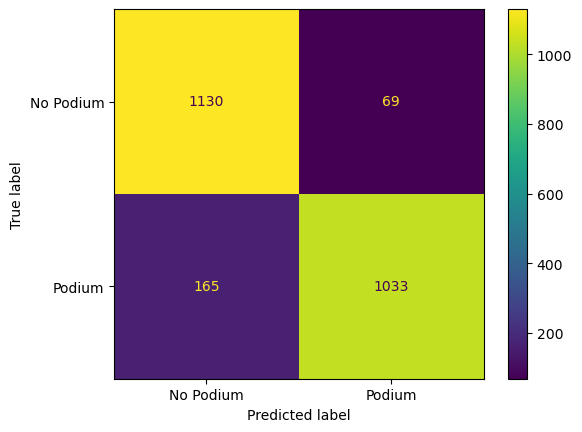

In [303]:
ConfusionMatrixDisplay.from_predictions( y_balanced_test, xgb_preds, display_labels=['No Podium', 'Podium'])

In [304]:
xgb_precision_score = precision_score(y_balanced_test, xgb_preds)
xgb_precision_score

0.9373865698729582

In [305]:
xgb_recall_score = recall_score(y_balanced_test, xgb_preds)
xgb_recall_score

0.8622704507512521

In [306]:
xgb_f05_score = (1.25 * xgb_precision_score * xgb_recall_score) / (0.25 * xgb_precision_score + xgb_recall_score)
xgb_f05_score

0.9213342846949696

Both Random Forest and XGBoost demonstrated slightly higher Precision and F0.5 Scores with a Decision Threshold of 0.9. As such, it is recommended to use this for future classification.